In [2]:
import json
import pprint

# dataset source
# https://files.pushshift.io/reddit/comments/
pp = pprint.PrettyPrinter(indent=4)

In [3]:
# access constants

ID = 'id'
BODY = 'body'
SCORE = 'score'
PARENT = 'parent_id'
LINK = 'link_id'

DATASET_FILE = 'reddit_2006jan.json'
QUERY_SUBREDDIT = 'reddit.com'

In [4]:
class Node(object):
    def __init__(self, body, score, parent, link):
        self.body = body
        self.score = score
        self.parent = parent
        self.link = link

In [5]:
# build dict of Node Objects by post id

def build_nodes_set(data):
    nodes = dict() # post_id: Node Object
    for post in data:
        nodes[post[ID]] = Node(post[BODY], post[SCORE], post[PARENT], post[LINK])
    return nodes

In [6]:
# build dict of post ids by link_id

def build_threads_set(nodes):
    threads = dict() # link_id: [post_ids]
    for post_id in nodes.keys():
        thread_id = nodes[post_id].link
        if thread_id in threads.keys():
            threads[thread_id].append(post_id)
        else:
            threads[thread_id] = [post_id]
    return threads

In [7]:
# builda dict of thread bodies by link_id

def build_thread_bodies(threads, nodes):
    thread_bodies = dict() # link_id: 'str w/ all comment text'
    for link_id in threads.keys():
        thread_bodies[link_id] = ""
        comments = threads[link_id]
        for post_id in comments:
            thread_bodies[link_id] += nodes[post_id].body

        # PARSE RULES #
        thread_bodies[link_id] = thread_bodies[link_id].replace('\n', '')
        thread_bodies[link_id] = thread_bodies[link_id].replace('\r', '')
    return thread_bodies

In [8]:
# read dataset

with open(DATASET_FILE) as file:
    train_data = json.loads(file.read())

# filter posts by subreddit

train_data = [post for post in train_data if post['subreddit'] == QUERY_SUBREDDIT]
print('{} results for query on subreddit: {}\n'.format(len(train_data), QUERY_SUBREDDIT))

# count up degenerate entries

no_id = [post for post in train_data if not ID in post]
print('{} entries without id'.format(len(no_id)))

no_body = [post for post in train_data if not BODY in post]
print('{} entries without body'.format(len(no_body)))

no_parent = [post for post in train_data if not PARENT in post]
print('{} entries without parent'.format(len(no_parent)))

no_link = [post for post in train_data if not LINK in post]
print('{} entries without link'.format(len(no_link)))

3664 results for query on subreddit: reddit.com

0 entries without id
0 entries without body
0 entries without parent
0 entries without link


In [9]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from stop_words import get_stop_words
from gensim import corpora, models

import numpy as np
import time

In [10]:
# gensim LDA library - ignore

tokenizer = RegexpTokenizer(r'\w+')
en_stop = set(get_stop_words('en'))
porter_stemmer = PorterStemmer()

clean = []
for idx, thread_body in enumerate(thread_bodies.values()):
    raw_text = thread_body.lower()
    tokens = tokenizer.tokenize(raw_text)
    stopped = [i for i in tokens if i not in en_stop]
    stemmed = [porter_stemmer.stem(i) for i in stopped]
    clean.append(stemmed)

# term_dict = corpora.Dictionary(clean)
# corpus = [term_dict.doc2bow(text) for text in clean]

# start = time.time()
# lda = models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS, id2word=term_dict, passes=PASSES)
# pp.pprint(lda.print_topics(num_topics=NUM_TOPICS, num_words=NUM_WORDS))
# end = time.time()

NameError: name 'thread_bodies' is not defined

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [13]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print('Topic {}:'.format(topic_idx))
        print(' '.join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print('')

In [14]:
NUM_TOPICS = 5
NUM_WORDS = 2
PASSES = 20

nodes = build_nodes_set(train_data)
threads = build_threads_set(nodes)
thread_bodies = build_thread_bodies(threads, nodes)

# train LDA model

start = time.time()

train = list(thread_bodies.values())
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
tf_train = tf_vectorizer.fit_transform(train)
tf_feature_names = tf_vectorizer.get_feature_names()

lda = LatentDirichletAllocation(n_topics=NUM_TOPICS, max_iter=PASSES, learning_method='online', learning_offset=50.,random_state=0)
lda.fit(tf_train)

display_topics(lda, tf_feature_names, NUM_WORDS)

end = time.time()

print('time elapsed: {} seconds'.format(end - start))

/Users/Peterli/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Topic 0:
deleted windows

Topic 1:
people like

Topic 2:
oil google

Topic 3:
just like

Topic 4:
http com

time elapsed: 6.087128162384033 seconds


In [15]:
# test prediction 

with open('reddit_2005dec.json') as file:
    test_data = json.loads(file.read())

nodes = build_nodes_set(test_data)
threads = build_threads_set(nodes)
thread_bodies = build_thread_bodies(threads, nodes)

# comment_bodies = { node_id: node.body for (node_id, node) in nodes.items() }
# test_set = list(comment_bodies.values())

test_set = list(thread_bodies.values())
tf_test = tf_vectorizer.fit_transform(test_set)
predict = lda.transform(tf_test)

pp.pprint(predict[:3])
print('')
print(test_set[0] + '\n')
print(test_set[1] + '\n')
print(test_set[2] + '\n\n')

pp.pprint(predict[-3:])
print('')
print(test_set[-3] + '\n')
print(test_set[-2] + '\n')
print(test_set[-1] + '\n\n')

array([[0.05232976, 0.53655661, 0.05006991, 0.30852102, 0.0525227 ],
       [0.00745875, 0.57534911, 0.00761521, 0.144825  , 0.26475192],
       [0.06667518, 0.72823481, 0.0710696 , 0.06733943, 0.06668097]])

A look at Vietnam and Mexico exposes the myth of market liberalisation.

The site states "What can I use it for? Meeting notes, Reports, technical specs Sign-up sheets, proposals and much more...", just like any other new breeed of sites that want us to store everything we have on the web. And they even guarantee multiple levels of security and encryption etc. But what prevents these web site operators fom accessing and/or stealing Meeting notes, Reports, technical specs Sign-up sheets, proposals and much more, for competitive or personal gains...? I am pretty sure that most of them are honest, but what's there to prevent me from setting up a good useful site and stealing all your data? Call me paranoid - I am.

Jython related topics by Frank Wierzbicki


array([[0.156999  , 0.411

In [16]:
print('predictions available for {} elements\n'.format(len(predict)))
pp.pprint(predict)

# not sure if this is chill
m, n = np.meshgrid(predict, predict)
dist_matrix = abs(m - n)

predictions available for 396 elements

array([[0.05232976, 0.53655661, 0.05006991, 0.30852102, 0.0525227 ],
       [0.00745875, 0.57534911, 0.00761521, 0.144825  , 0.26475192],
       [0.06667518, 0.72823481, 0.0710696 , 0.06733943, 0.06668097],
       ...,
       [0.156999  , 0.41127412, 0.10943053, 0.25145537, 0.07084097],
       [0.00691655, 0.63011907, 0.04981258, 0.00733707, 0.30581473],
       [0.02222729, 0.21748446, 0.02280595, 0.71453702, 0.02294528]])


In [18]:
# build adjacency list (lookup table)
# ASSUMPTION: dict.keys() and dict.values() directly correspond if not modified

DIST_THRES = 0.03

# rehydrate node_ids into dist_matrix -> distance lookup table

max_dist = float('-inf')

dist_lookup = { node_id: {} for node_id in thread_bodies.keys() }
for idx1, first in enumerate(list(dist_lookup.keys())):
    for idx2, second in enumerate(list(dist_lookup.keys())):
        dist_lookup[first][second] = 1 if dist_matrix[idx1][idx2] <= DIST_THRES else 0
        max_dist = dist_matrix[idx1][idx2] if dist_matrix[idx1][idx2] > max_dist else max_dist
#         dist_lookup[first][second] = dist_matrix[idx1][idx2] # lazy eval

# check

mistakes = 0
for i in dist_lookup.keys():
    for j in dist_lookup.keys():
        if i==j and dist_lookup[i][j] != 1:
            mistakes += 1
        if dist_lookup[i][j] != dist_lookup[j][i]:
            mistakes += 1

print('max distance seen: {}'.format(max_dist))
print('{} mistakes out of {} entries'.format(mistakes, len(dist_lookup) * len(dist_lookup)))

max distance seen: 0.9675498598448601
0 mistakes out of 156816 entries


In [19]:
import networkx as nx
import matplotlib.pyplot as plt

g = nx.Graph()
for thread_id in thread_bodies.keys():
    g.add_node(thread_id)

for first in thread_bodies.keys():
    for second in thread_bodies.keys():
        if not g.has_edge(first, second) and dist_lookup[first][second] == 1:
            g.add_edge(first, second)

# start = time.time()
# nx.draw(g)
# plt.show()
# end = time.time()


# print('time elapsed: {} seconds'.format(end - start))

In [20]:
print(nx.is_connected(g))
degs = nx.degree_histogram(g)
# plt.hist(degs, normed=True, bins=len(degs))
# nx.density(g)
print(nx.info(g))

False
Name: 
Type: Graph
Number of nodes: 396
Number of edges: 14829
Average degree:  74.8939


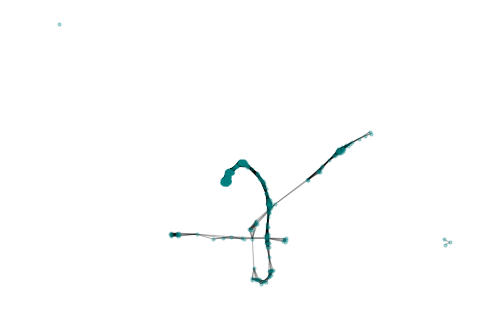

In [21]:
# visualize network

# nx.draw(gr)
# nx.draw_random(gr)
# nx.draw_circular(gr)
# nx.draw_spectral(gr)
nx.draw(g, **{
    'with_labels': False,
    'node_size': 10,
    'node_color': 'teal',
    'alpha': 0.3,
})
plt.axis('off')
# plt.savefig('graph.pdf', dpi=1000)
nx.write_graphml(g, 'topic_relevance.graphml')
plt.show()

In [ ]:
# dump network

